In [1]:
!pip install shap
!pip install catboost

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy.spatial import cKDTree

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from scipy.spatial import cKDTree
from sklearn.feature_selection import mutual_info_regression
from catboost import CatBoostRegressor, Pool
import shap
import seaborn as sns
from sklearn.model_selection import cross_val_score



In [2]:
# Load datasets
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
toilets = pd.read_csv("toilets.csv")
waste_management = pd.read_csv("waste_management.csv")
water_sources = pd.read_csv("water_sources.csv")

In [3]:
# Combine train and test datasets for consistent preprocessing
hospital_data = pd.concat([train, test])

In [4]:
# Drop unnecessary columns from supplementary datasets
for df in [toilets, waste_management, water_sources]:
    df.drop(columns=['Year', 'Month'], inplace=True)

In [5]:
# Rename columns for clarity
def rename_columns(df, prefix):
    for col in df.columns:
        if col not in ['Month_Year_lat_lon', 'lat_lon']:
            df.rename(columns={col: f"{prefix}_{col}"}, inplace=True)

rename_columns(toilets, "toilet")
rename_columns(waste_management, "waste")
rename_columns(water_sources, "water")


In [6]:
# Fill missing values in the 'Total' column
hospital_data['Total'].fillna(0, inplace=True)

<ipython-input-6-868d1139418e>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  hospital_data['Total'].fillna(0, inplace=True)


In [7]:
# Drop rows with missing latitude and longitude in water sources
water_sources.dropna(subset=['water_Transformed_Latitude'], inplace=True)

In [8]:
# Drop duplicates
hospital_data.drop_duplicates(inplace=True)
toilets.drop_duplicates(inplace=True)
waste_management.drop_duplicates(inplace=True)
water_sources.drop_duplicates(inplace=True)

In [9]:
# Visualize locations for a specific year and month
# Note the months/year should in the given timeframe [2019, 2023]
def plot_locations(year=2022, month=1, month_name='January'):
    if year < 2019 or year > 2023:
        print("Invalid year. Please choose a year between 2019 and 2023.")
        return

    if month < 1 or month > 12:
        print("Invalid month. Please choose a month between 1 and 12.")
        return

    if month_name.capitalize() not in ['January', 'February', 'March',
                                       'April', 'May', 'June', 'July',
                                       'August', 'September', 'October',
                                       'November', 'December']:
        print("Invalid month name. Please choose from 'January' to 'December'.")
        return

    plt.figure(figsize=(12, 8))
    subsets = [
        (hospital_data.query(f"Year == {year} and Month == {month}"), 'Transformed', 'Hospital', 's'),
        (water_sources.query(f"water_Month_Year == '{month}_{year}'"), 'water_Transformed', 'Water', 'o'),
        (waste_management.query(f"waste_Month_Year == '{month}_{year}'"), 'waste_Transformed', 'Waste', 'x'),
        (toilets.query(f"toilet_Month_Year == '{month}_{year}'"), 'toilet_Transformed', 'Toilet', '^'),
    ]
    for df, prefix, label, marker in subsets:
        plt.scatter(df[f'{prefix}_Longitude'], df[f'{prefix}_Latitude'], label=label, alpha=0.6, marker=marker)
    plt.title(f'Locations ({month_name.capitalize()} {year})')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True)
    plt.show()

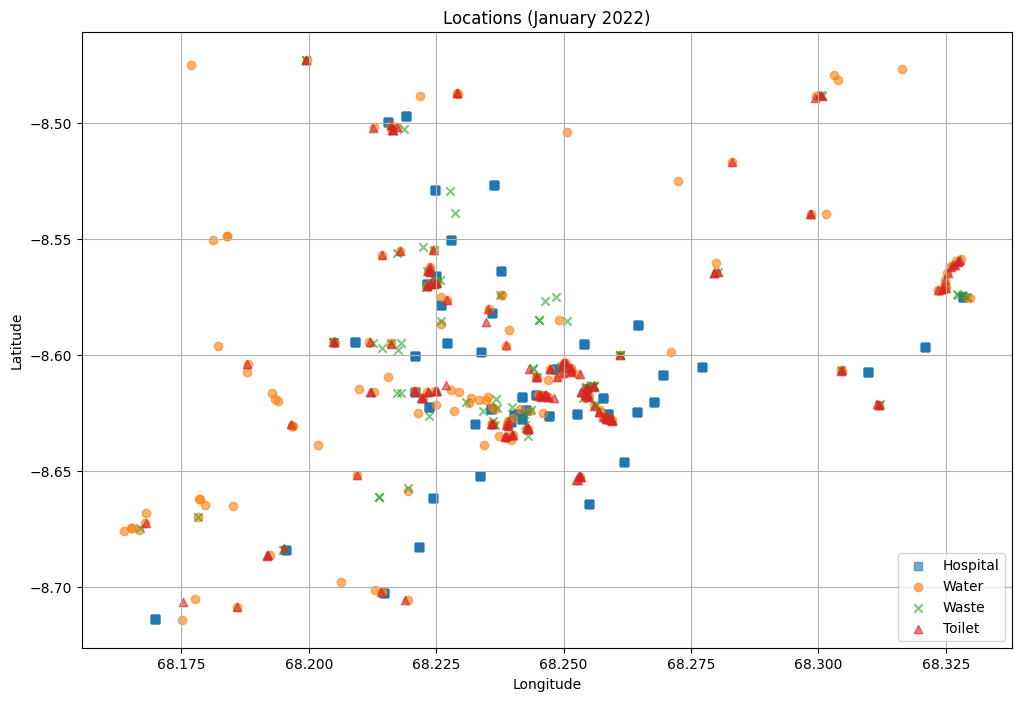

In [10]:
plot_locations()

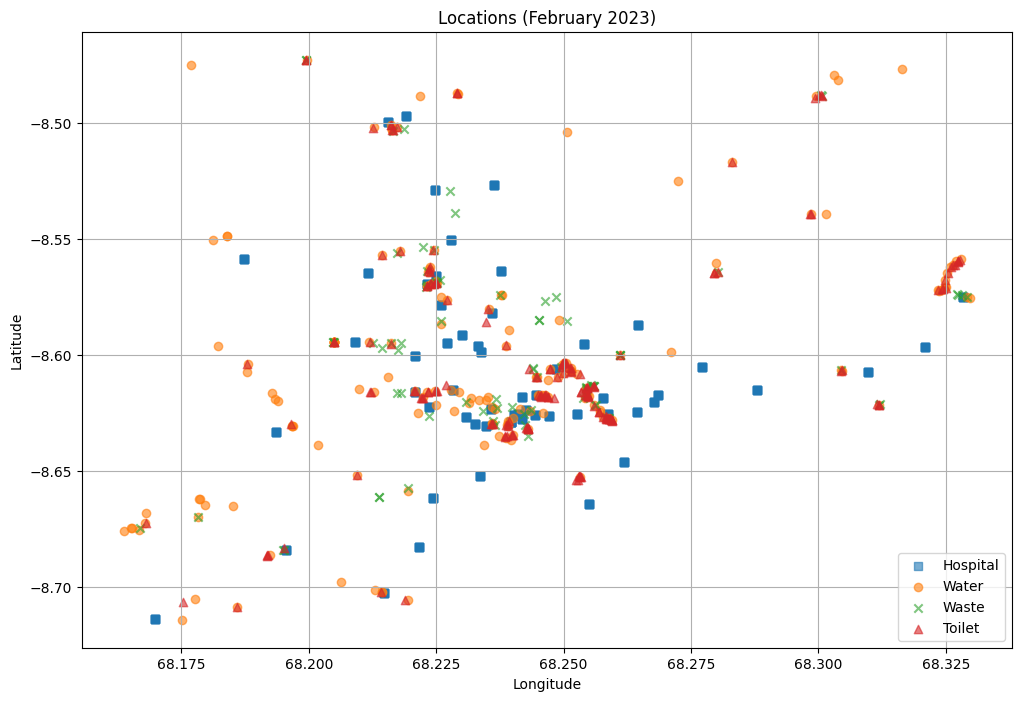

In [11]:
plot_locations(year=2023, month=2, month_name='February')

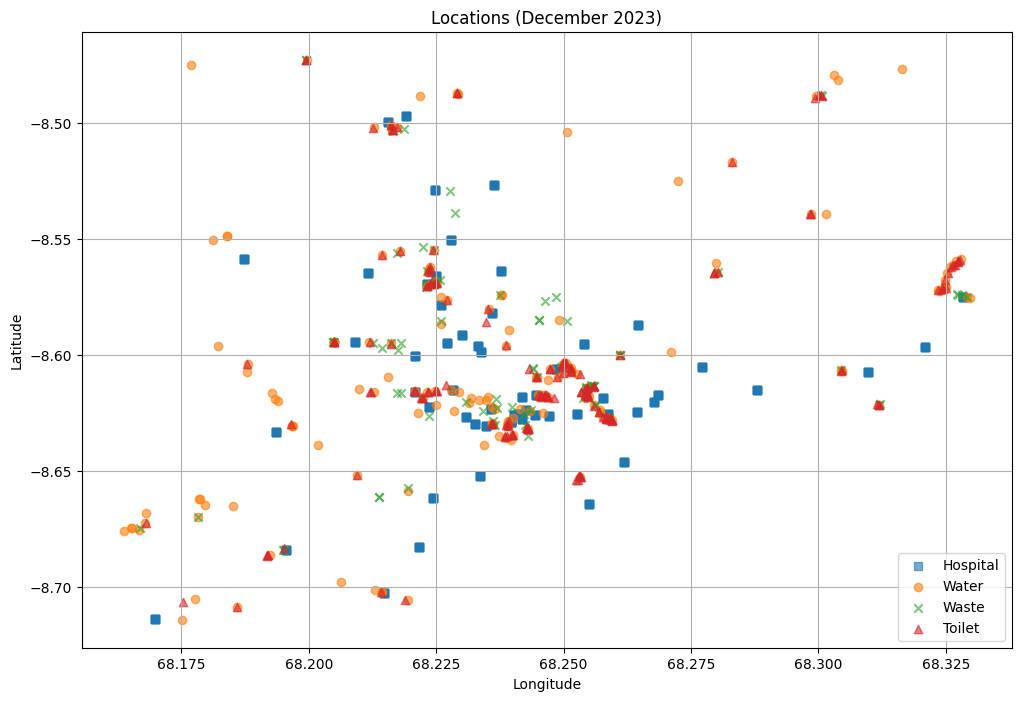

In [12]:
plot_locations(year=2023, month=12, month_name='December')

In [13]:
plot_locations(year=2000, month=1, month_name='January')

Invalid year. Please choose a year between 2019 and 2023.


In [14]:
def find_nearest(hospital_df, location_df, lat_col, lon_col, id_col):
    # Create a cKDTree for efficient nearest neighbour search
    tree = cKDTree(location_df[[lat_col, lon_col]].values)
    nearest = {}
    # Loop through each hospital and find the nearest site in location_df
    for _, row in hospital_df.iterrows():
        _, idx = tree.query([row['Transformed_Latitude'], row['Transformed_Longitude']])
        nearest[row['ID']] = location_df.iloc[idx][id_col]
    return nearest


In [14]:
# Ensure unique identifier columns exist in all supplementary datasets
for df, prefix in [(toilets, 'toilet'), (waste_management, 'waste'), (water_sources, 'water')]:
    df[f"{prefix}_Month_Year_lat_lon"] = (
        df[f"{prefix}_Month_Year"] + '_' +
        df[f"{prefix}_Transformed_Latitude"].astype(str) + '_' +
        df[f"{prefix}_Transformed_Longitude"].astype(str)
    )

In [15]:
toilets.head()

,toilet_10u,toilet_10v,toilet_2d,toilet_2t,toilet_evabs,toilet_evaow,toilet_evatc,toilet_evavt,toilet_albedo,toilet_lshf,...,toilet_swvl1,toilet_swvl2,toilet_swvl3,toilet_swvl4,toilet_Transformed_Latitude,toilet_Transformed_Longitude,toilet_Month_Year,lat_lon,Month_Year_lat_lon,toilet_Month_Year_lat_lon
0,-1.006850,-0.714544,293.502,297.417,-0.002489,-0.001031,-0.000989,-3.445890e-08,0.173221,0.650001,...,0.346542,0.335724,0.264359,0.300018,-8.61768,68.24536,1_2019,-8.61768_68.24536,1_2019_-8.61768_68.24536,1_2019_-8.61768_68.24536
1,-1.408560,-0.662555,292.943,297.978,-0.002556,-0.001076,-0.000734,-3.818420e-08,0.173808,0.650001,...,0.254517,0.259918,0.281769,0.296188,-8.61768,68.24536,2_2019,-8.61768_68.24536,2_2019_-8.61768_68.24536,2_2019_-8.61768_68.24536
2,-0.892110,-0.449448,293.250,297.989,-0.002535,-0.000980,-0.000713,-3.678720e-08,0.178823,0.650001,...,0.278152,0.284195,0.261597,0.291672,-8.61768,68.24536,3_2019,-8.61768_68.24536,3_2019_-8.61768_68.24536,3_2019_-8.61768_68.24536
3,-0.392348,0.384925,293.934,296.542,-0.001748,-0.000658,-0.001343,-2.700840e-08,0.180959,0.650017,...,0.385513,0.378616,0.309784,0.288925,-8.61768,68.24536,4_2019,-8.61768_68.24536,4_2019_-8.61768_68.24536,4_2019_-8.61768_68.24536
4,-0.447104,0.581028,292.571,294.726,-0.001374,-0.000462,-0.001139,-2.048910e-08,0.182375,0.650009,...,0.397659,0.400055,0.392654,0.309311,-8.61768,68.24536,5_2019,-8.61768_68.24536,5_2019_-8.61768_68.24536,5_2019_-8.61768_68.24536


In [17]:
# Merge datasets based on 'Month_Year'
merged_data = hospital_data.copy()

# Create a combined Month_Year column in hospital_data
merged_data['Month_Year'] = merged_data['Month'].astype(str) + '_' + merged_data['Year'].astype(str)

datasets = [
    (toilets, 'toilet', 'toilet_Month_Year_lat_lon'),
    (waste_management, 'waste', 'waste_Month_Year_lat_lon'),
    (water_sources, 'water', 'water_Month_Year_lat_lon'),
]
grp_cols = ['ID', 'Location','Category_Health_Facility_UUID', 'Disease', 'Month', 'Year', 'Transformed_Latitude', 'Transformed_Longitude']
merged_data = merged_data.groupby(grp_cols, as_index=False)[['Total']].max()

merged_data.loc[~merged_data['Category_Health_Facility_UUID'].isin(list(set(merged_data['Category_Health_Facility_UUID']))), 'Category_Health_Facility_UUID'] = 'other'
merged_data = pd.get_dummies(data = merged_data, columns=['Category_Health_Facility_UUID'], dtype=int)

df_month_year = merged_data[['Year','Month']].drop_duplicates().sort_values(by=['Year','Month'], ignore_index=True)
df_month_year['month_year'] = df_month_year.index
merged_data = merged_data.merge(df_month_year, on = ['Year','Month'], how='left')

In [19]:
merged_data = merged_data.drop_duplicates()

In [20]:
merged_data.shape

(17873, 179)

In [21]:
merged_data.head()

,ID,Location,Disease,Month,Year,Transformed_Latitude,Transformed_Longitude,Total,Category_Health_Facility_UUID_56cd4cbb-23db-4dde-a6ae-9fc1ed7c8662,Category_Health_Facility_UUID_56cd4cbb-23db-4dde-a6ae-9fc1ed7c8663,...,Category_Health_Facility_UUID_a3761841-2a02-4c17-8589-d35aac4edc93,Category_Health_Facility_UUID_a3761841-2a02-4c17-8589-d35aac4edc94,Category_Health_Facility_UUID_a3761841-2a02-4c17-8589-d35aac4edc95,Category_Health_Facility_UUID_a3761841-2a02-4c17-8589-d35aac4edc96,Category_Health_Facility_UUID_a3761841-2a02-4c17-8589-d35aac4edc97,Category_Health_Facility_UUID_a3761841-2a02-4c17-8589-d35aac4edc98,Category_Health_Facility_UUID_a3761841-2a02-4c17-8589-d35aac4edc99,Category_Health_Facility_UUID_a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Category_Health_Facility_UUID_b7f0a600-e19e-4c65-acb3-e28584dae35b,month_year
0,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_10_201...,ID_00cd8292-dd85-4fa3-8148-9592e88a1651,Diarrhea,10,2019,-8.52657,68.23638,12.0,0,0,...,0,0,0,0,0,0,0,1,0,9
1,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_10_201...,ID_00cd8292-dd85-4fa3-8148-9592e88a1651,Dysentery,10,2019,-8.52657,68.23638,0.0,0,0,...,0,0,0,0,0,0,0,1,0,9
2,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_10_201...,ID_00cd8292-dd85-4fa3-8148-9592e88a1651,Intestinal Worms,10,2019,-8.52657,68.23638,23.0,0,0,...,0,0,0,0,0,0,0,1,0,9
3,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_10_201...,ID_00cd8292-dd85-4fa3-8148-9592e88a1651,Malaria,10,2019,-8.52657,68.23638,3.0,0,0,...,0,0,0,0,0,0,0,1,0,9
4,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_10_201...,ID_00cd8292-dd85-4fa3-8148-9592e88a1651,Schistosomiasis,10,2019,-8.52657,68.23638,0.0,0,0,...,0,0,0,0,0,0,0,1,0,9


<ipython-input-22-d7b48b2f04d1>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_data['Month_Year'] = pd.to_datetime(merged_data['Month'].astype(str) + '-' + merged_data['Year'].astype(str))


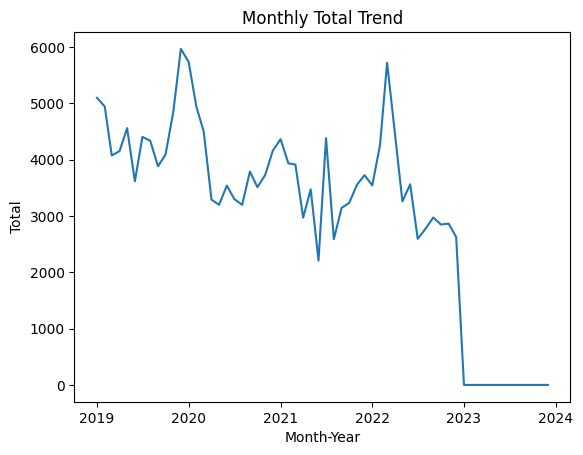

In [22]:
# Assuming 'merged_data' contains your combined dataset
merged_data['Month_Year'] = pd.to_datetime(merged_data['Month'].astype(str) + '-' + merged_data['Year'].astype(str))
monthly_totals = merged_data.groupby('Month_Year')['Total'].sum()
plt.plot(monthly_totals.index, monthly_totals.values)
plt.title('Monthly Total Trend')
plt.xlabel('Month-Year')
plt.ylabel('Total')
plt.show()

In [ ]:
!pip install plotly

## Start modeling

In [23]:
# Split merged data into train and test sets
train_df = merged_data[merged_data['Year'] < 2023]
test_df = merged_data[merged_data['Year'] == 2023]

In [24]:
# Specify the target column
target_column = 'Total'

# Feature and target split
X = train_df.drop(columns=[target_column, 'ID', 'Location'])  # Exclude unnecessary columns
y = train_df[target_column]

In [25]:
# Handle categorical features
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])


In [26]:
# Assuming 'X' is your feature matrix and 'y' is your target variable
X = train_df.drop(columns=['Total', 'ID', 'Location'])  # Exclude unnecessary columns
y = train_df['Total']

# Handle categorical features (including datetime)
categorical_cols = X.select_dtypes(include=['object', 'datetime64']).columns # Include 'datetime64'

for col in categorical_cols:
    if pd.api.types.is_datetime64_any_dtype(X[col]):  # If column is datetime
        X[col + '_year'] = X[col].dt.year  # Extract year
        X[col + '_month'] = X[col].dt.month  # Extract month
        X.drop(columns=[col], inplace=True)  # Drop original datetime column
    else:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

# Calculate mutual information
mi_scores = mutual_info_regression(X, y)

# Print or use the MI scores
print(mi_scores)

[2.41880543e-01 3.27113897e-02 2.00973459e-02 1.29637753e-01
 1.28468820e-01 9.66223266e-03 0.00000000e+00 3.84789757e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.18610221e-02
 0.00000000e+00 9.68593238e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.02073330e-04 5.02542853e-03
 1.00978566e-02 0.00000000e+00 5.61863348e-04 3.57943938e-03
 8.10432692e-03 0.00000000e+00 0.00000000e+00 1.24978119e-03
 0.00000000e+00 1.48881246e-03 1.03210313e-02 0.00000000e+00
 5.06750376e-03 8.68762841e-03 0.00000000e+00 1.24613636e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 6.01704588e-03 0.00000000e+00
 3.86712941e-03 0.00000000e+00 7.81767139e-03 4.82263752e-03
 4.54283400e-03 1.24371846e-02 0.00000000e+00 0.00000000e+00
 2.33394786e-03 6.83367962e-04 0.00000000e+00 0.00000000e+00
 3.83595873e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.51889606e-03 0.00000000e+00 9.34182890e-03 0.00000000e+00
 0.00000000e+00 9.668305

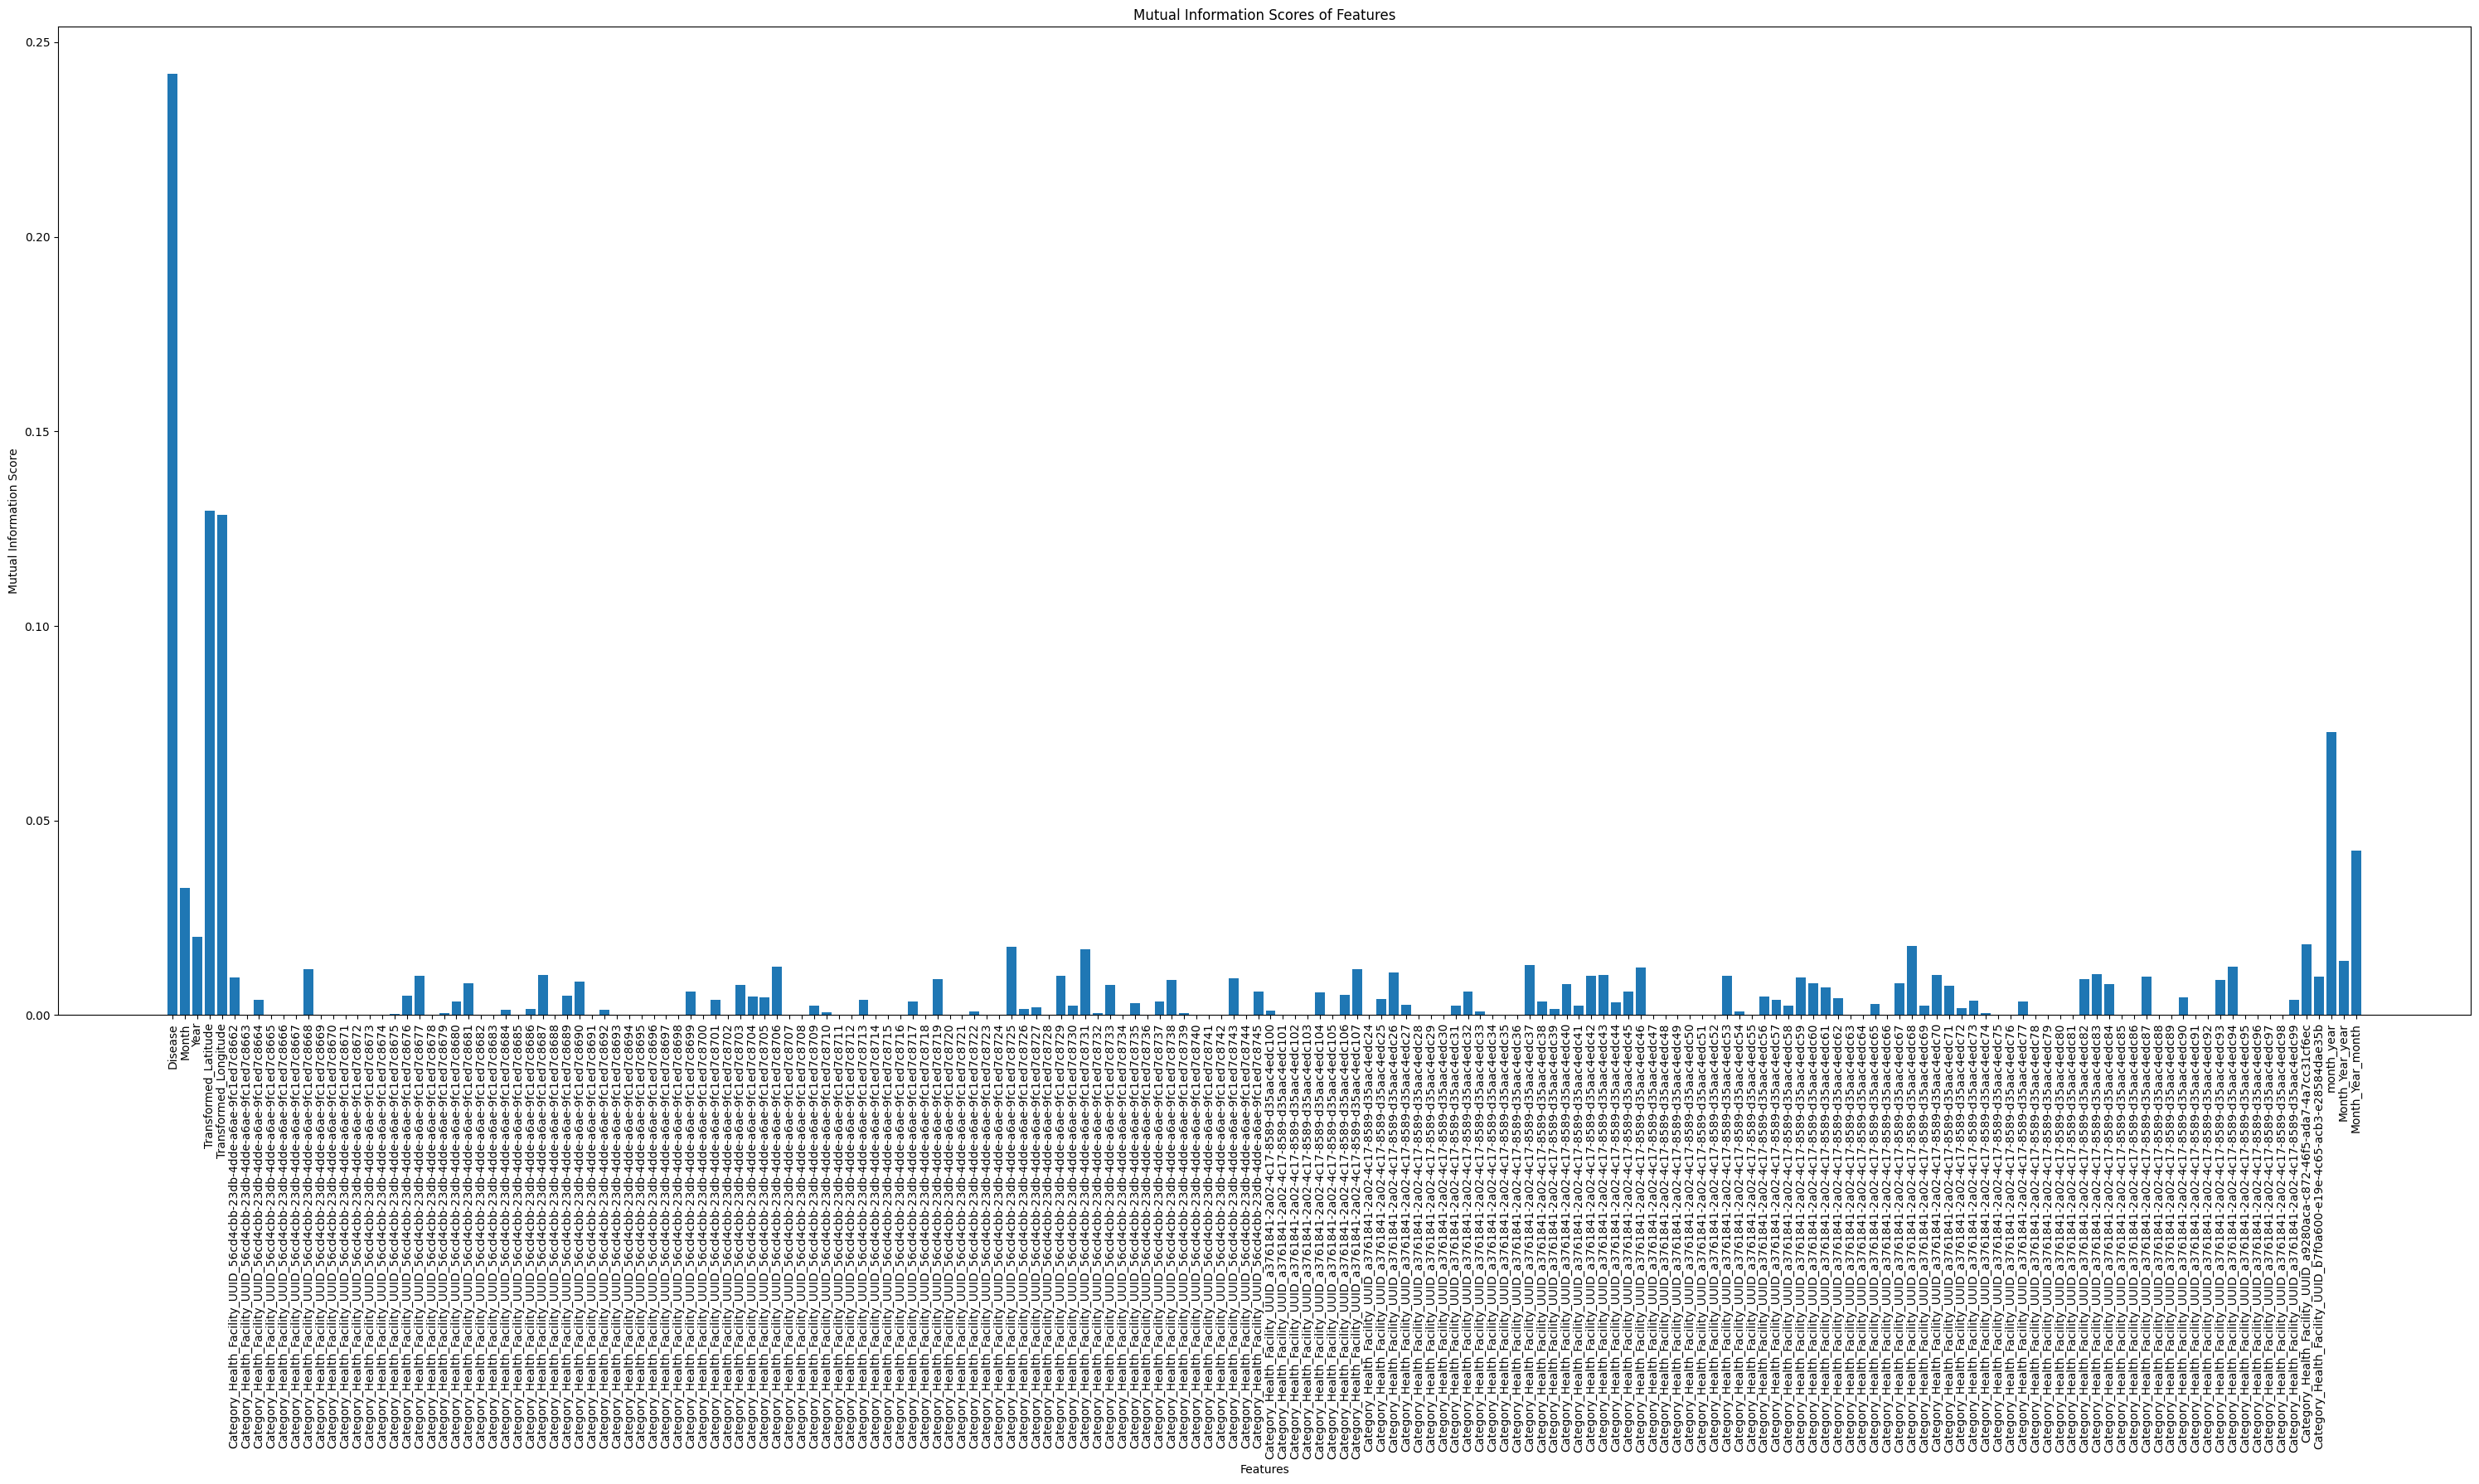

In [27]:
# plot the mi in a graph

import matplotlib.pyplot as plt

# 'mi_scores' is already calculated as in previous code
# and X contains the feature names

# Create a bar plot of MI scores
plt.figure(figsize=(30, 18))
plt.bar(X.columns, mi_scores)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Mutual Information Score")
plt.title("Mutual Information Scores of Features")
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [28]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# Cat boost model
# Best hyperparameters: {'iterations': 2380, 'learning_rate': 0.0639842751981036, 'depth': 8, 'l2_leaf_reg': 6}
# Best MAE: 8.040348959817987
#  then apply shap for feature selection


# Initialize CatBoostRegressor with provided hyperparameters
model = CatBoostRegressor(
    iterations=2380,
    learning_rate=0.0639842751981036,
    depth=8,
    l2_leaf_reg=6,
    loss_function='MAE',
    random_seed=42,
    verbose=100
)

# Fit the model
model.fit(X_train, y_train, eval_set=(X_test, y_test))

# Make predictions
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
print(f"CV MAE: {-cv_scores.mean()}")


0:	learn: 14.3362482	test: 12.4380484	best: 12.4380484 (0)	total: 51.3ms	remaining: 2m 2s
100:	learn: 9.8446461	test: 9.0980642	best: 9.0980642 (100)	total: 861ms	remaining: 19.4s
200:	learn: 8.9510272	test: 8.4715062	best: 8.4715062 (200)	total: 1.81s	remaining: 19.6s
300:	learn: 8.3116002	test: 8.0736257	best: 8.0736257 (300)	total: 2.8s	remaining: 19.4s
400:	learn: 7.9213217	test: 7.8579849	best: 7.8567117 (399)	total: 4.9s	remaining: 24.2s
500:	learn: 7.5925836	test: 7.7430867	best: 7.7359300 (480)	total: 6.24s	remaining: 23.4s
600:	learn: 7.3678197	test: 7.6877815	best: 7.6861968 (597)	total: 7.63s	remaining: 22.6s
700:	learn: 7.1482331	test: 7.6133862	best: 7.6133851 (699)	total: 8.48s	remaining: 20.3s
800:	learn: 6.9868114	test: 7.6069736	best: 7.6041714 (793)	total: 9.26s	remaining: 18.3s
900:	learn: 6.8224517	test: 7.5524096	best: 7.5506087 (896)	total: 10s	remaining: 16.4s
1000:	learn: 6.6531759	test: 7.5240666	best: 7.5233082 (997)	total: 10.8s	remaining: 14.8s
1100:	learn: 

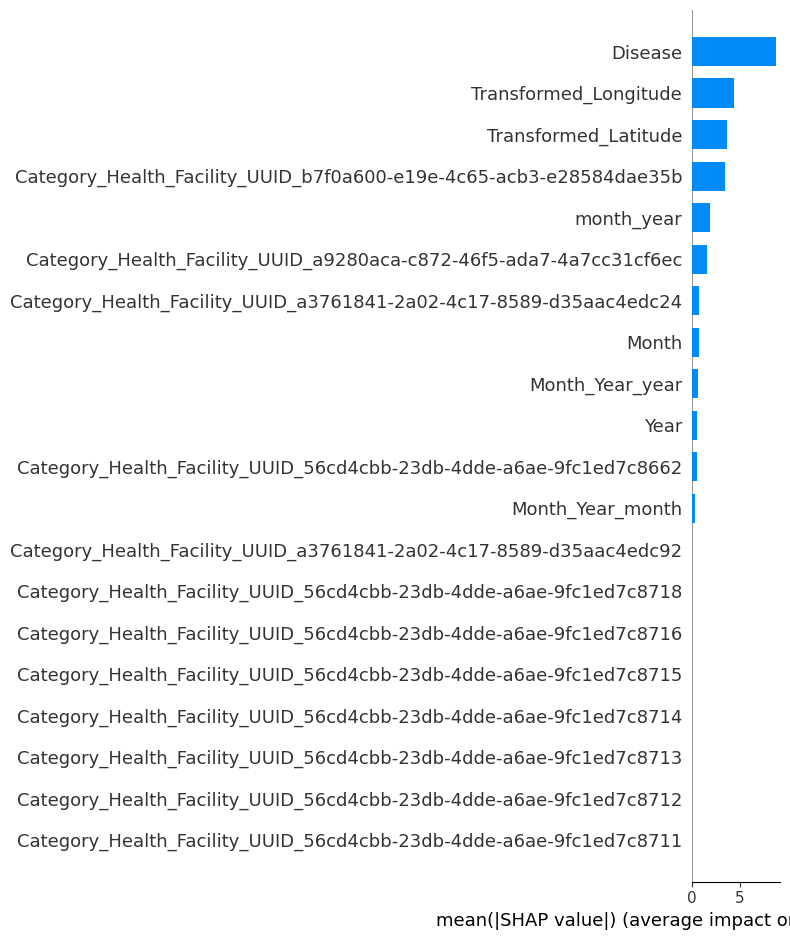

In [30]:
shap.initjs()

# Apply SHAP for feature importance
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Further analysis with SHAP values (e.g., individual predictions)
shap.plots.force(explainer.expected_value, shap_values.values[0], X_test.iloc[0])

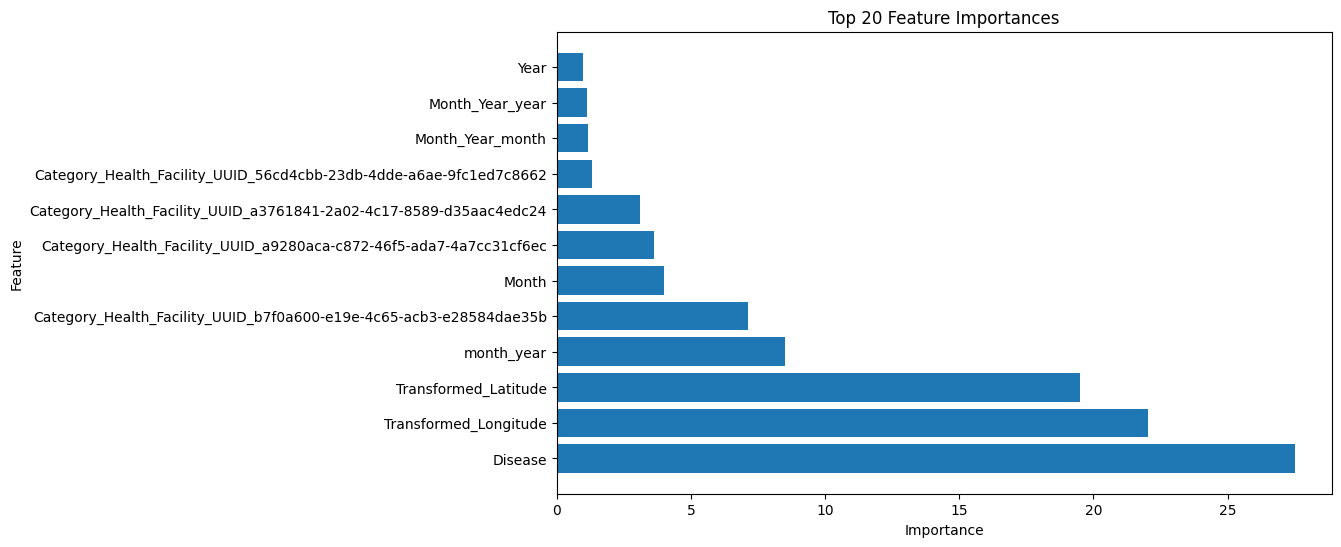

Top 20 Important Features:


,Feature Id,Importances
0,Disease,27.497706
1,Transformed_Longitude,22.017210
2,Transformed_Latitude,19.499338
3,month_year,8.512216
4,Category_Health_Facility_UUID_b7f0a600-e19e-4c...,7.138453
5,Month,3.991161
6,Category_Health_Facility_UUID_a9280aca-c872-46...,3.642188
7,Category_Health_Facility_UUID_a3761841-2a02-4c...,3.111320
8,Category_Health_Facility_UUID_56cd4cbb-23db-4d...,1.304602
9,Month_Year_month,1.151781


In [31]:
#feature importance graph for the catboost model, create a list ordered from hightest to lowest


# Get feature importances from the trained CatBoost model
feature_importances = model.get_feature_importance(prettified=True)

# Create a list of features ordered by importance (highest to lowest)
ordered_features = feature_importances.sort_values('Importances', ascending=False)

# Remove features with zero importance
important_features = ordered_features[ordered_features['Importances'] > 0]

# Select the top 20 most important features
top_20_features = important_features.head(20)

# Extract feature names and importances for plotting
feature_names = top_20_features['Feature Id'].tolist()
importances = top_20_features['Importances'].tolist()

# Create the feature importance plot
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.show()

# Print the list of top 20 important features
print("Top 20 Important Features:")
top_20_features

In [37]:
# prompt: retrain model using the top 11 features

# Select the top 11 features
top_11_features = important_features.head(11)['Feature Id'].tolist()

# Retrain the model using only the top 11 features
X_train_top_11 = X_train[top_11_features]
X_test_top_11 = X_test[top_11_features]

model_top_11 = CatBoostRegressor(
    iterations=2380,
    learning_rate=0.0639842751981036,
    depth=8,
    l2_leaf_reg=6,
    loss_function='MAE',
    random_seed=42,
    verbose=100
)

model_top_11.fit(X_train_top_11, y_train, eval_set=(X_test_top_11, y_test))

# Make predictions with the retrained model
y_pred_top_11 = model_top_11.predict(X_test_top_11)

# Evaluate the retrained model
mae_top_11 = mean_absolute_error(y_test, y_pred_top_11)
print(f"Mean Absolute Error (Top 11 Features): {mae_top_11}")


0:	learn: 14.2979662	test: 12.4038419	best: 12.4038419 (0)	total: 4.06ms	remaining: 9.66s
100:	learn: 9.9633395	test: 9.1480122	best: 9.1480122 (100)	total: 365ms	remaining: 8.22s
200:	learn: 9.1012986	test: 8.5714101	best: 8.5714101 (200)	total: 719ms	remaining: 7.79s
300:	learn: 8.5399248	test: 8.2260516	best: 8.2239887 (299)	total: 1.05s	remaining: 7.24s
400:	learn: 8.0890256	test: 7.9342505	best: 7.9342505 (400)	total: 1.7s	remaining: 8.41s
500:	learn: 7.7879705	test: 7.7894685	best: 7.7866381 (499)	total: 2.54s	remaining: 9.52s
600:	learn: 7.5191105	test: 7.6686321	best: 7.6686321 (600)	total: 3.21s	remaining: 9.49s
700:	learn: 7.3033762	test: 7.6058528	best: 7.6001401 (699)	total: 4.1s	remaining: 9.81s
800:	learn: 7.0761253	test: 7.5567844	best: 7.5565789 (799)	total: 5.01s	remaining: 9.87s
900:	learn: 6.8813508	test: 7.5106210	best: 7.5087337 (888)	total: 5.33s	remaining: 8.75s
1000:	learn: 6.7575183	test: 7.5114874	best: 7.5087337 (888)	total: 5.67s	remaining: 7.82s
1100:	learn

#### Make predictions on test

In [39]:
# Prepare test data
X_test_final = test_df.drop(columns=['Total', 'ID', 'Location'], errors='ignore')

In [40]:
# Handle categorical features in test data
for col in categorical_cols:
    if col in X_test_final.columns:
        le = LabelEncoder()
        X_test_final[col] = le.fit_transform(X_test_final[col])

In [41]:
# Align test dataset with training features
for col in X.columns:
    if col not in X_test_final.columns:
        X_test_final[col] = 0  # Add missing feature with default value (e.g., zero)


In [42]:
# Ensure columns are in the same order as training
X_test_final = X_test_final[X.columns]

In [44]:
# Make predictions on test data
predictions = model_top_11.predict(X_test_final)

In [45]:
# Create the final DataFrame with ID and predictions
sub = test_df[['ID']].copy()
sub['Predicted_Total'] = predictions

In [46]:
# View the first few records in sub
sub.head()

,ID,Predicted_Total
24,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_10_202...,0.695611
25,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_10_202...,4.796813
26,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_10_202...,-0.443551
27,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_10_202...,6.051132
28,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_10_202...,3.019475


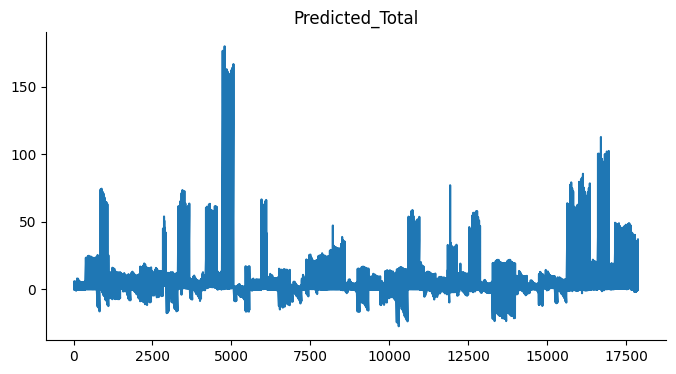

In [47]:
# @title Predicted_Total

from matplotlib import pyplot as plt
sub['Predicted_Total'].plot(kind='line', figsize=(8, 4), title='Predicted_Total')
plt.gca().spines[['top', 'right']].set_visible(False)

In [48]:
# Save the final DataFrame to a CSV
sub.to_csv('Benchmark_5.0.csv', index=False)